In [1]:
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import os
from tqdm import tqdm
import time
import seaborn as sns
import warnings
import multiprocessing
from functools import partial
from scipy import stats

sns.set(style="dark", color_codes=True)
warnings.filterwarnings("ignore")

This script was written to examine whether genes with low exon-captured percentages actually did also not show up in capture arrays of cancer tissues. The file, complete_genome_data was taken from gencode_analysis script, including information about capture coverage and numbers of exons of protein coding genes. Based on that file, we will select two groups, 100% and below 30% coverage 

In [2]:
complete_gene_info = pd.read_csv('complete_genome_data.txt', sep ="\t")
gene_names = np.array(complete_gene_info.gene_id)

28 selected tissue samples common cancer tissues of interest. Edata contains expression levels of every gene per sample tissue.

In [4]:
edata = pd.read_csv('TCGA-FPKMUQ-polyA-riboD-capture-revised', index_col=0) 

In [5]:
#pcg for protein coding genes
edata_pcg = edata[np.append(['tissue','type','sample_type'], complete_gene_info.gene_id)]

In [6]:
#28 sample names
sp_names = np.array(list(set(['-'.join(name.split(sep='-')[:-1]) for name in edata_pcg.index])))
sp_names.shape

(28,)

In [58]:
tissue_types = np.array(list(set(edata_pcg.tissue)))
tissue_types

array(['UCEC', 'LUAD', 'BRCA', 'BLCA', 'KIRC', 'COAD'], dtype='<U4')

Collection of functions for data manipulation and plotting

In [62]:
def np_subwhere(str_arr, substr):
    """Return indexes of all strings in a list that contain the substring"""
    str_arr = np.array(str_arr, dtype = str)
    index =  np.flatnonzero(np.core.defchararray.find(str_arr, substr)!=-1)
    if index.shape[0]==0:
        return [-1]
    else:
        return index

def collect_sample(sp_name, data, tissue_type = False):
    """Transpose a selected sample dataset for plotting"""
    sp_data = data.iloc[np_subwhere(data.index, sp_name)]
    sp_data = sp_data.T
    sp_data.columns = sp_data.loc['sample_type']
    if tissue_type:
        return sp_data.drop(sp_data.index[[1,2]])
    else:
        return sp_data.iloc[3:]

def plot_polyA_capture_riboD(data):
    """Superpose all sample types (FFPE/FF, capture/polyA)"""
    data = pd.DataFrame.copy(data)
    sp_preps = np.array(data.columns) #record columns
    log2_data = pd.DataFrame(index = data.index)
    for prep_type in sp_preps:
        log2_data['log2_'+prep_type] = np.log2(np.array(data[prep_type], dtype=float)+1.)
    if np.array(log2_data.columns).shape[0]!=4:
        raise ValueError(' ')
        
    log2_cols = np.array(log2_data.columns)
    plot_table = pd.DataFrame(columns=['X','Y','label'])
    temp_plot_table = pd.DataFrame(columns=['X','Y','label'])
    for i in [0,1]:
        temp_plot_table['X'] = log2_data[log2_cols[i]]
        for k in [2,3]:
            temp_plot_table['Y'] = log2_data[log2_cols[k]]
            temp_plot_table['label'] = [log2_cols[k]+'-'+log2_cols[i] for l in range(len(data))]
            plot_table = pd.concat([plot_table, temp_plot_table], axis = 0)
    #plot all together
    g = sns.lmplot(x='X', y='Y', hue='label', data=plot_table, markers=['o', '^','x','<'], legend_out=True,\
                   aspect=1.5)
    

def sep_plot_polyA_capture_riboD(data):
    """Separate plots"""
    data = pd.DataFrame.copy(data)
    sp_preps = np.array(data.columns)
    log2_data = pd.DataFrame(index = data.index)
    for prep_type in sp_preps:
        log2_data['log2_'+prep_type] = np.log2(np.array(data[prep_type], dtype=float)+1.)
    if np.array(log2_data.columns).shape[0]!=4:
        raise ValueError(' ')
        
    log2_cols = np.array(log2_data.columns)
    temp_plot_table = pd.DataFrame()
    
    #plot
    fig = plt.figure(figsize=(10,10))
    axes = {}
    for i in range(4):
        axes[i]= fig.add_subplot(2,2,i+1)
    legends = []
    m=0
    for i in [0,1]:
        temp_plot_table[log2_cols[i]] = log2_data[log2_cols[i]]
        for k in [2,3]:
            temp_plot_table[log2_cols[k]] = log2_data[log2_cols[k]]
            sns.regplot(log2_cols[i], log2_cols[k], data=temp_plot_table,\
                        ax=axes[m], scatter_kws={"alpha":0.15})
        
            m+=1
            
          
    

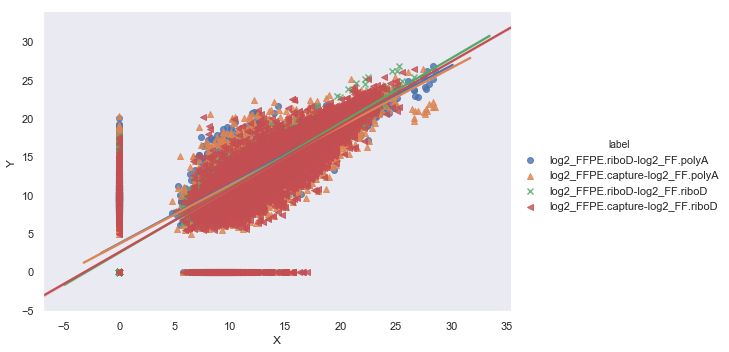

In [10]:
data = collect_sample(sp_name=sp_names[15] , data=edata_pcg)
data2 =plot_polyA_capture_riboD(data)

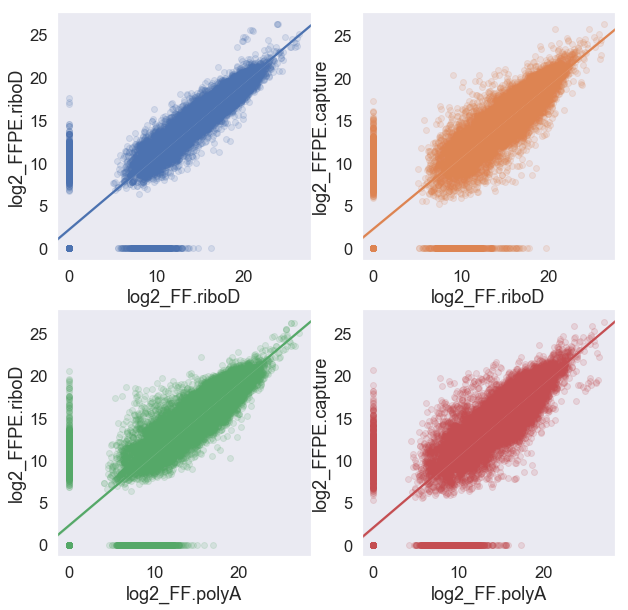

In [61]:
data = collect_sample(sp_name=sp_names[26] , data=edata_pcg)
sep_plot_polyA_capture_riboD(data)

plot less than 50% data

In [12]:
def replace_df_portion(ori_df, df_tb_replace):
    """Replace subset of dataframe with new data by rows"""
    ori_df = pd.DataFrame.copy(ori_df)
    replace_indexes = np.array(df_tb_replace.index) #new indexes
    replace_elements = [df_tb_replace.iloc[i].tolist() for i in range(replace_indexes.shape[0])]
    ori_df.loc[replace_indexes] = replace_elements
    return ori_df

def plot_polyAwcapture_covered(data, complete_gene_info):
    """Plotting both groups of <30% and 100% captured"""
    data = pd.DataFrame.copy(data)
    sp_preps = np.array(data.columns)
    log2_data = pd.DataFrame(index = data.index)
    for prep_type in sp_preps:
        log2_data['log2_'+prep_type] = np.log2(np.array(data[prep_type], dtype=float)+1.)
    
    
    gene_less_30 = np.array(complete_gene_info[complete_gene_info["%exon_bases_ovl"]<.3]['gene_id'], dtype='str').tolist() #genes with more than 30% covered
    gene_abv_100 = np.array(complete_gene_info[complete_gene_info["%exon_bases_ovl"]==1.0]['gene_id'], dtype='str').tolist() #genes with 100% covered
    
    log2_cols = np.array(log2_data.columns)
    temp_table = pd.DataFrame(columns=['CAP_covered?'])
    
    markers = ['>','o']
    
    for i in [0,1]:
        temp_table[log2_cols[i]] = log2_data[log2_cols[i]]
        temp_table['log2_FFPE.capture'] = log2_data['log2_FFPE.capture']
        gene_table_less_30 = temp_table.loc[gene_less_30]
        gene_table_abv_100 = temp_table.loc[gene_abv_100]
        gene_table_less_30['CAP_covered?'] = '<30%'
        gene_table_abv_100['CAP_covered?'] = '=100%'
        temp_table = replace_df_portion(temp_table,gene_table_less_30)
        temp_table = replace_df_portion(temp_table,gene_table_abv_100)
        g= sns.FacetGrid(temp_table, hue="CAP_covered?", size=5,hue_order=['<30%','=100%' ],\
                         hue_kws={'marker':["^", "v"], 'cmap':'jet'})\
           .map(plt.scatter, log2_cols[i], "log2_FFPE.capture", alpha = .3)\
           .add_legend()
        g= sns.regplot(x=log2_cols[i], y="log2_FFPE.capture", data=temp_table, scatter=False,\
                 scatter_kws={"alpha":0.05})
        

def sep_plot_polyAwcapture_covered(data, complete_gene_info, outlier_percent, target_percent):
    "Seperate plots of 30% and 100%"
    data = pd.DataFrame.copy(data)
    sp_preps = np.array(data.columns)
    log2_data = pd.DataFrame(index = data.index)
    for prep_type in sp_preps:
        log2_data['log2_'+prep_type] = np.log2(np.array(data[prep_type], dtype=float)+1.)
    
    
    gene_less = np.array(complete_gene_info\
                            [complete_gene_info["%exon_bases_ovl"]<outlier_percent/100]['gene_id']\
                            , dtype='str').tolist()
    gene_abv = np.array(complete_gene_info\
                            [complete_gene_info["%exon_bases_ovl"]>=target_percent/100]['gene_id']\
                            , dtype='str').tolist()
    
    log2_cols = np.array(log2_data.columns)
    
    temp_table = pd.DataFrame(columns=['CAP_covered?'])

    fig = plt.figure(figsize=(10,5))
    
    legends=[]

    markers = ['>','o']
    axes = {}
    for i in range(2):
        axes[i]= fig.add_subplot(1,2,i+1)
    m=0
    colors = ['blue','green']
    CAP_types = ['>='+str(target_percent)+' percent','<'+str(outlier_percent)+' percent']
    temp_table['log2_FF.polyA'] = log2_data['log2_FF.polyA']
    temp_table['log2_FFPE.capture'] = log2_data['log2_FFPE.capture']
    gene_table_less = temp_table.loc[gene_less]
    gene_table_abv = temp_table.loc[gene_abv]
    gene_tables = [gene_table_abv, gene_table_less]
    temp_table = replace_df_portion(temp_table,gene_table_less)
    temp_table = replace_df_portion(temp_table,gene_table_abv)
    
    for k in range(2):
        data = gene_tables[k]
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(data['log2_FF.polyA'],data["log2_FFPE.capture"])

        a = sns.regplot(x='log2_FF.polyA', y="log2_FFPE.capture", data=gene_tables[k], scatter=True,\
             label = 'y = '+str(round(slope,2))+'x + '+str(round(intercept,2))+ '\n R^2 = '+str(round(r_value**2,2)),\
                        scatter_kws={"alpha":0.05, "color": colors[k]}, ax=axes[m])

        plt.tight_layout()
        axes[m].set_title(CAP_types[k])
        axes[m].legend(loc = 'best')

        m+=1
    return gene_tables


        

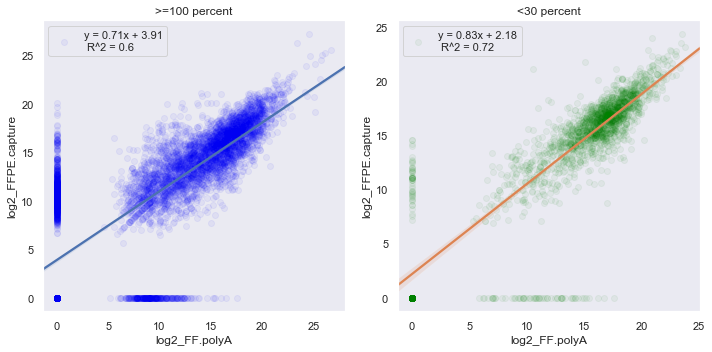

In [13]:
data = collect_sample(sp_name=sp_names[0] , data=edata_pcg)
tables = sep_plot_polyAwcapture_covered(data, complete_gene_info, 30, 100)


The next step applied to get rid of zeroes on either axes to see whether those datapoints in the middle are linearly correlated.

In [66]:
def sep_plot_polyAwcapture_covered_rm_zeros(data, complete_gene_info, outlier_percent, target_percent):
    """Plotting polyA against capture without zeroes on either axes"""
    data = pd.DataFrame.copy(data)
    sp_preps = np.array(data.columns)
    log2_data = pd.DataFrame(index = data.index)
    for prep_type in sp_preps:
        log2_data['log2_'+prep_type] = np.log2(np.array(data[prep_type], dtype=float)+1.)
      
    #find genes captured less than outlier_percent (30%)
    gene_less = np.array(complete_gene_info\
                            [complete_gene_info["%exon_bases_ovl"]<=outlier_percent/100]['gene_id']\ 
                            , dtype='str').tolist()
    #find genes captured with target percent (100%)
    gene_abv = np.array(complete_gene_info\
                            [complete_gene_info["%exon_bases_ovl"]>=target_percent/100]['gene_id']\
                            , dtype='str').tolist()
    genes_dif_ex = [gene_abv,gene_less]
    log2_cols = np.array(log2_data.columns)
    temp_table = pd.DataFrame()

    fig = plt.figure(figsize=(10,5))
    
    legends = []
    axes = {}
    for i in range(2):
        axes[i]= fig.add_subplot(1,2,i+1)
    m=0
    colors = ['blue','green']
    CAP_types = ['>='+str(target_percent)+' percent','<'+str(outlier_percent)+' percent']
  
    temp_table['log2_FF.polyA'] = log2_data['log2_FF.polyA']
    temp_table['log2_FFPE.capture'] = log2_data['log2_FFPE.capture']

    gene_outliers = temp_table[(temp_table['log2_FF.polyA'] * temp_table['log2_FFPE.capture']==0) &\ #gene_outliers not include genes are both zero expressions
                                       ((temp_table['log2_FF.polyA'] - temp_table['log2_FFPE.capture'])!=0)].index.tolist()
    genes_off_target = temp_table[(temp_table['log2_FF.polyA'] * temp_table['log2_FFPE.capture']==0)].index.tolist() #genes off target are zeroes in either expressions
    
    
    gene_less_rm_olr_n0 = list(set(gene_less)-set(genes_off_target)) #genes less than 30% without zeores and and off target
    gene_less_rm_olr = list(set(gene_less)-set(gene_outliers)) #includes (0,0) genes
    
    gene_abv_rm_olr_n0 = list(set(gene_abv)-set(genes_off_target))
    gene_abv_rm_olr = list(set(gene_abv)-set(gene_outliers))
    gene_table_less = temp_table.loc[gene_less_rm_olr_n0]
    gene_table_abv = temp_table.loc[gene_abv_rm_olr_n0]
    gene_tables = [gene_table_abv, gene_table_less]
    genes_on_target_rm_olr = [gene_abv_rm_olr,gene_less_rm_olr]
    

    for k in range(2):
        data_plot = gene_tables[k]
        slope, intercept, r_value, p_value, std_err = stats.linregress(data_plot['log2_FF.polyA'],data_plot["log2_FFPE.capture"])
        num_genes = len(genes_dif_ex[k])
        num_outliers = num_genes-len(genes_on_target_rm_olr[k])
        percent_outliers = round(num_outliers*100/num_genes,1)
        a = sns.regplot(x='log2_FF.polyA', y="log2_FFPE.capture", data=data_plot, scatter=True,\
             label = 'y = '+str(round(slope,2))+'x + '+str(round(intercept,2))+ '\n R^2 = '+str(round(r_value**2,3))\
                        +'\n #total = '+str(num_genes)+'\n # outliers = '\
                        +str(num_outliers)+' as '+str(percent_outliers)+'% of total'\
                        , scatter_kws={"alpha":0.05, "color": colors[k]}, ax=axes[m])
        
        plt.tight_layout()
        axes[m].set_title(CAP_types[k])
        axes[m].legend(loc = 'best')

        m+=1
        
    return temp_table.loc[gene_outliers], complete_gene_info[complete_gene_info.gene_id.isin(gene_outliers)]


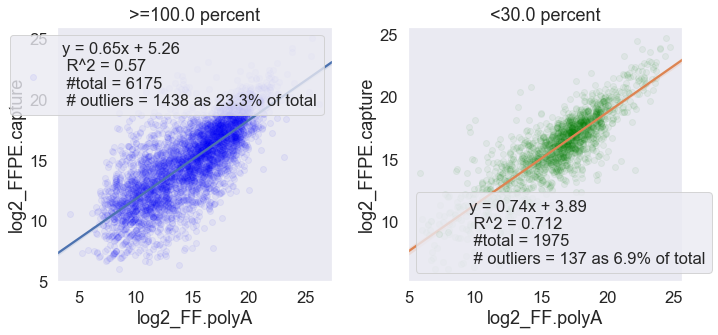

In [69]:
data = collect_sample(sp_name=sp_names[19] , data=edata_pcg)
olr_abv, olr_less = sep_plot_polyAwcapture_covered_rm_zeros(data, complete_gene_info, 30., 100.)

In [23]:
def plot_outliers(data):
    """This suggests the expression levels of captures are slightly higher than polyA"""
    data = pd.DataFrame.copy(data)
    sp_preps = np.array(data.columns)
    log2_data = pd.DataFrame(index = data.index)
    for prep_type in sp_preps:
        log2_data['log2_'+prep_type] = np.log2(np.array(data[prep_type], dtype=float)+1.)

    log2_data = log2_data[['log2_FF.polyA','log2_FFPE.capture']]
    log2_cols = np.array(log2_data.columns)
    log2_data = log2_data[log2_data[log2_cols[0]]*log2_data[log2_cols[1]]==0]
    log2_data.replace(0.,np.nan, inplace=True)
    log2_data.dropna(axis = 0, how='all', inplace= True)
    
    log2_data.replace(np.nan, 0., inplace=True)
    log2_data['type'] = np.nan
    fig, axes = plt.subplots(figsize=(20,10))
    for i in range(2):
        temp_table = log2_data[log2_data[log2_cols[i]]!=0.]
        temp_table['type'] = log2_cols[i]
        log2_data = replace_df_portion(log2_data, temp_table)
    log2_data['exp_levels']=log2_data[log2_cols[0]].replace(0.,log2_data[log2_cols[1]])
    a = sns.boxplot(x='type', y='exp_levels', data=log2_data, width=0.5, ax=axes)
    a = sns.swarmplot(x='type', y='exp_levels', data=log2_data, size = 3, color='Blue', ax=axes, alpha=0.3)
    
    

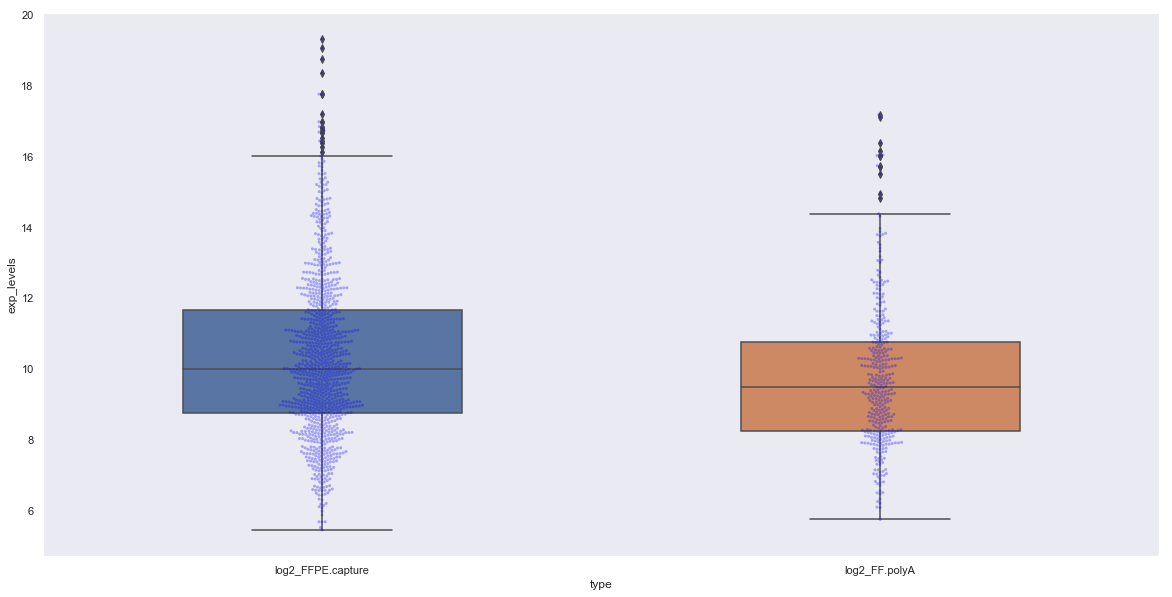

In [24]:
plot_outliers(data)

In [70]:
#edata_pcg.to_csv('protein_coding_FFKM')

High frequency of appearance genes in both capture and polyA

In [29]:
def find_sp_name(sp_list):
    names = np.array(list(set(['-'.join(name.split(sep='-')[:-1]) for name in sp_list])))
    return names

def rm_inconsistent_exp_genes(table, appear_freq):
    #remove genes that have inconsitent expressions across collected samples:
    table = pd.DataFrame.copy(table)
    table.replace(0,np.nan, inplace=True)
    nan_counts= np.array(table.isnull().sum(axis=1).tolist())

    samples_count = table.shape[1]
    table['appear_freq'] = nan_counts/samples_count
    table = table.loc[table.appear_freq<1.-appear_freq]
    table.drop('appear_freq', axis =1, inplace=True)
    table.replace(np.nan, 0., inplace=True)
    return table

def avg_consistent_exp_genes(table, appear_freq):
    table = pd.DataFrame.copy(table)
    table = rm_inconsistent_exp_genes(table, appear_freq)
    table['mean'] = table.mean(axis=1, skipna= True)
    table = table['mean']
    return table

def set_log2_table(exp_data, sp_name, tissue_type=False):
    exp_data = pd.DataFrame.copy(exp_data)
    data = collect_sample(sp_name, exp_data, tissue_type)
    sp_preps = np.array(data.columns)
    tissue_types = pd.DataFrame(data.iloc[0]).T
    #return data
    data = data.iloc[1:]
    log2_data = pd.DataFrame(index = data.index)
    
    for prep_type in sp_preps:
        log2_data['log2_'+prep_type] = np.log2(np.array(data[prep_type], dtype=float)+1.)
    tissue_types.columns = log2_data.columns
    sp_name = pd.DataFrame([[sp_name]*np.array(log2_data.columns).shape[0]], columns=np.array(log2_data.columns))

    log2_data = pd.concat([sp_name,tissue_types, log2_data], axis=0)
    return log2_data

def plot_all_polyAwcapture_covered_rm_zeros(exp_data, patient_name, appear_freq):
    """obtain elimination_table that only have polyA and capture across all samples"""
    exp_data = pd.DataFrame.copy(exp_data)
    patient_data = exp_data.iloc[np_subwhere(exp_data.index,patient_name)]
    tissue_type = np.array(patient_data['tissue'])[0]
    exp_data = exp_data[exp_data.tissue == tissue_type]
    names = find_sp_name(np.array(exp_data.index))

    patient_table = set_log2_table(patient_data, patient_name)
    #return patient_table
    patient_cols = np.array(patient_table.columns)
    #return patient_table
    patient_table = patient_table[['log2_FF.polyA','log2_FFPE.capture']]

    elimination_table = pd.DataFrame()
    for name in names:
        temp_table = set_log2_table(exp_data, name)

        temp_table = temp_table[temp_table.columns[np_subwhere(temp_table.columns, 'polyA')] |\
                               temp_table.columns[np_subwhere(temp_table.columns, 'capture')]]

        elimination_table = pd.concat([elimination_table, temp_table],\
                                      axis = 1)

    polyA_table = elimination_table[elimination_table.columns[np_subwhere(elimination_table.columns,'polyA')]]
    selected_genes = np.array(complete_gene_info\
                            [complete_gene_info["%exon_bases_ovl"]>=appear_freq/100.]['gene_name']\
                            , dtype='str').tolist()
    
    capture_table = elimination_table[elimination_table.columns[np_subwhere(elimination_table.columns,'capture')]]
    capture_genes= np.array(avg_consistent_exp_genes(capture_table, appear_freq).index)
    #final_genes = list(set(capture_genes) & set(polyA_genes)) #this could be used for looking at expression across different tissues
    final_genes = selected_genes

    patient_table = patient_table.loc[final_genes]
    patient_table.columns = ['log2_polyA', 'log2_capture']
    patient_table.replace(0., np.nan, inplace=True)
    patient_table.dropna(how='any', inplace=True)
    patient_table = patient_table.iloc[1:].astype(float)

    slope, intercept, r_value, p_value, std_err = stats.linregress(patient_table)
    fig = plt.figure(figsize=(10,10))
    
    axes= fig.add_subplot(1,1,1)
    a = sns.regplot(x='log2_polyA', y='log2_capture', data=patient_table, scatter=True,\
                    label = 'y = '+str(round(slope,2))+'x + '+str(round(intercept,2))+ '\n R^2 = '+str(round(r_value**2,3)),\
                                scatter_kws={"alpha":0.05}, ax=axes)
    axes.set_title(patient_name+' ('+tissue_type+') - '+str(appear_freq) +'% captured')
    axes.legend(loc = 'best')
    
    return elimination_table

Copy all datasets before adding correction factors to them

In [30]:
genes = edata_pcg[edata_pcg.columns[3:]].columns
cp_complete_gene_info = complete_gene_info.set_index(['gene_id'])
cp_edata_pcg = pd.DataFrame(edata_pcg) #change gene id to gene names
genes_edata_pcg = cp_edata_pcg[cp_edata_pcg.columns[3:]]
genes_edata_pcg.columns = np.array(cp_complete_gene_info.loc[genes].gene_name)

In [73]:
cp_edata_pcg = pd.concat([edata_pcg[edata_pcg.columns[:3]], genes_edata_pcg], axis = 1)

## PLOTTING PER TISSUE

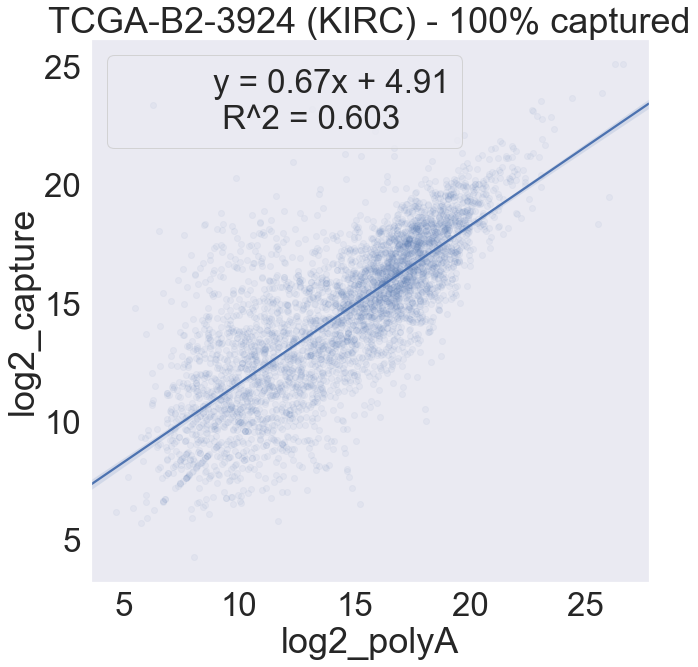

In [32]:
#data = collect_sample(sp_name=sp_names[26] , data=edata_pcg)
sns.set(style="dark", color_codes=True, font_scale=3)
elimination_table = plot_all_polyAwcapture_covered_rm_zeros(cp_edata_pcg,sp_names[3], 100)

In [34]:
def polyAncapture_per_gene(exp_data, percent = 0.):
    """only return polyA and capture per gene"""
    exp_data = pd.DataFrame.copy(exp_data)
    tissue_type = np.array(exp_data['tissue'])[0]
    names = find_sp_name(np.array(exp_data.index))

    elimination_table = pd.DataFrame()
    for name in names:
        temp_table = set_log2_table(exp_data, name, tissue_type=True)

        temp_table = temp_table[temp_table.columns[np_subwhere(temp_table.columns, 'polyA')] |\
                               temp_table.columns[np_subwhere(temp_table.columns, 'capture')]]

        elimination_table = pd.concat([elimination_table, temp_table],\
                                      axis = 1)
    elimination_table.rename(columns={ 'log2_FFPE.capture':'capture', 'log2_FF.polyA':'polyA'}, inplace=True)
    return elimination_table

def catplot_polyA_bet_capture(axes, genes_profile, gene_name, tissues = tissue_types, complete_gene_info = complete_gene_info, stop_legend = False):
    """plotting expression differences between capture and polyA per gene"""
    genes_profile = pd.DataFrame.copy(genes_profile)
    gene_profile = genes_profile.loc[[0,'tissue',gene_name]]
    gene_profile = gene_profile.T.reset_index()

    palettes = ['Blues', 'Reds', 'Greens', 'magma_r','rainbow', 'viridis']
    i=0
    store_leg_handles =[]
    for tissue in tissues:
        data_plot = gene_profile.loc[gene_profile.tissue ==tissue]
        data_plot[0] = data_plot[0] +' : '+ data_plot.tissue
        g = sns.FacetGrid(data_plot,legend_out=True)
        g.map(sns.pointplot, "index", gene_name,hue=0, color="0.", palette = sns.color_palette(palette=palettes[i],n_colors=1),\
        ci=None, ax = axes, data = data_plot, legend_out = True, legend=False)
        
        i+=1
        store_leg_handles.append(axes.get_legend_handles_labels()[0])
        plt.close(2)
        
    if stop_legend:
        axes.get_legend().remove()
    else:
        axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes.set_xlabel(' ')
    axes.set_ylabel('FPKM-UQ')
    axes.set_title(gene_name +' -  '+ str(np.array(complete_gene_info[complete_gene_info.gene_name == gene_name]['#GC_bases'])[0])+' bases  - '\
                                                +str(round(np.array(complete_gene_info[complete_gene_info.gene_name == gene_name]['%bases_ovl'])[0]*100.,2))+\
                   '% captured')

    return gene_profile

def multi_catplot_polyA_bet_capture(genes_profile, gene_names, stop_final_legend = True):
    """wrapper function for categorical plot above"""
    fig = plt.figure(figsize=(20,20))
    axes = {}
    for i in range(len(gene_names)):
        if len(gene_names)>1:
            axes[i]= fig.add_subplot(int(np.ceil(len(gene_names)/2)),2,i+1)
        else:
            axes[i]  = fig.add_subplot(1,1,1)
        
    for i in range(len(gene_names)):
        if i < len(gene_names)-1:
            catplot_polyA_bet_capture(axes[i], genes_profile, gene_names[i],stop_legend=True)
        else:
            catplot_polyA_bet_capture(axes[i], genes_profile, gene_names[i],stop_legend=stop_final_legend)
        plt.tight_layout()
    
    #return
    

In [35]:
genes_profile = polyAncapture_per_gene(cp_edata_pcg)

In [36]:
#multi_catplot_polyA_bet_capture(genes_profile, ['CD8A','FOXP3','CD68','CD163','GZMA','GZMB','PRF1','TNF','IFNG',\
 #                                               'ASPM','CDK1','CDC20','CDKN3','CENPF','HMGB2','HPRT1','MCM2','NEIL3',\
  #                                              'PCNA','PIF1','POLE2','RAN','TK1','TOP2A','TUBA1A','UHRF1'])

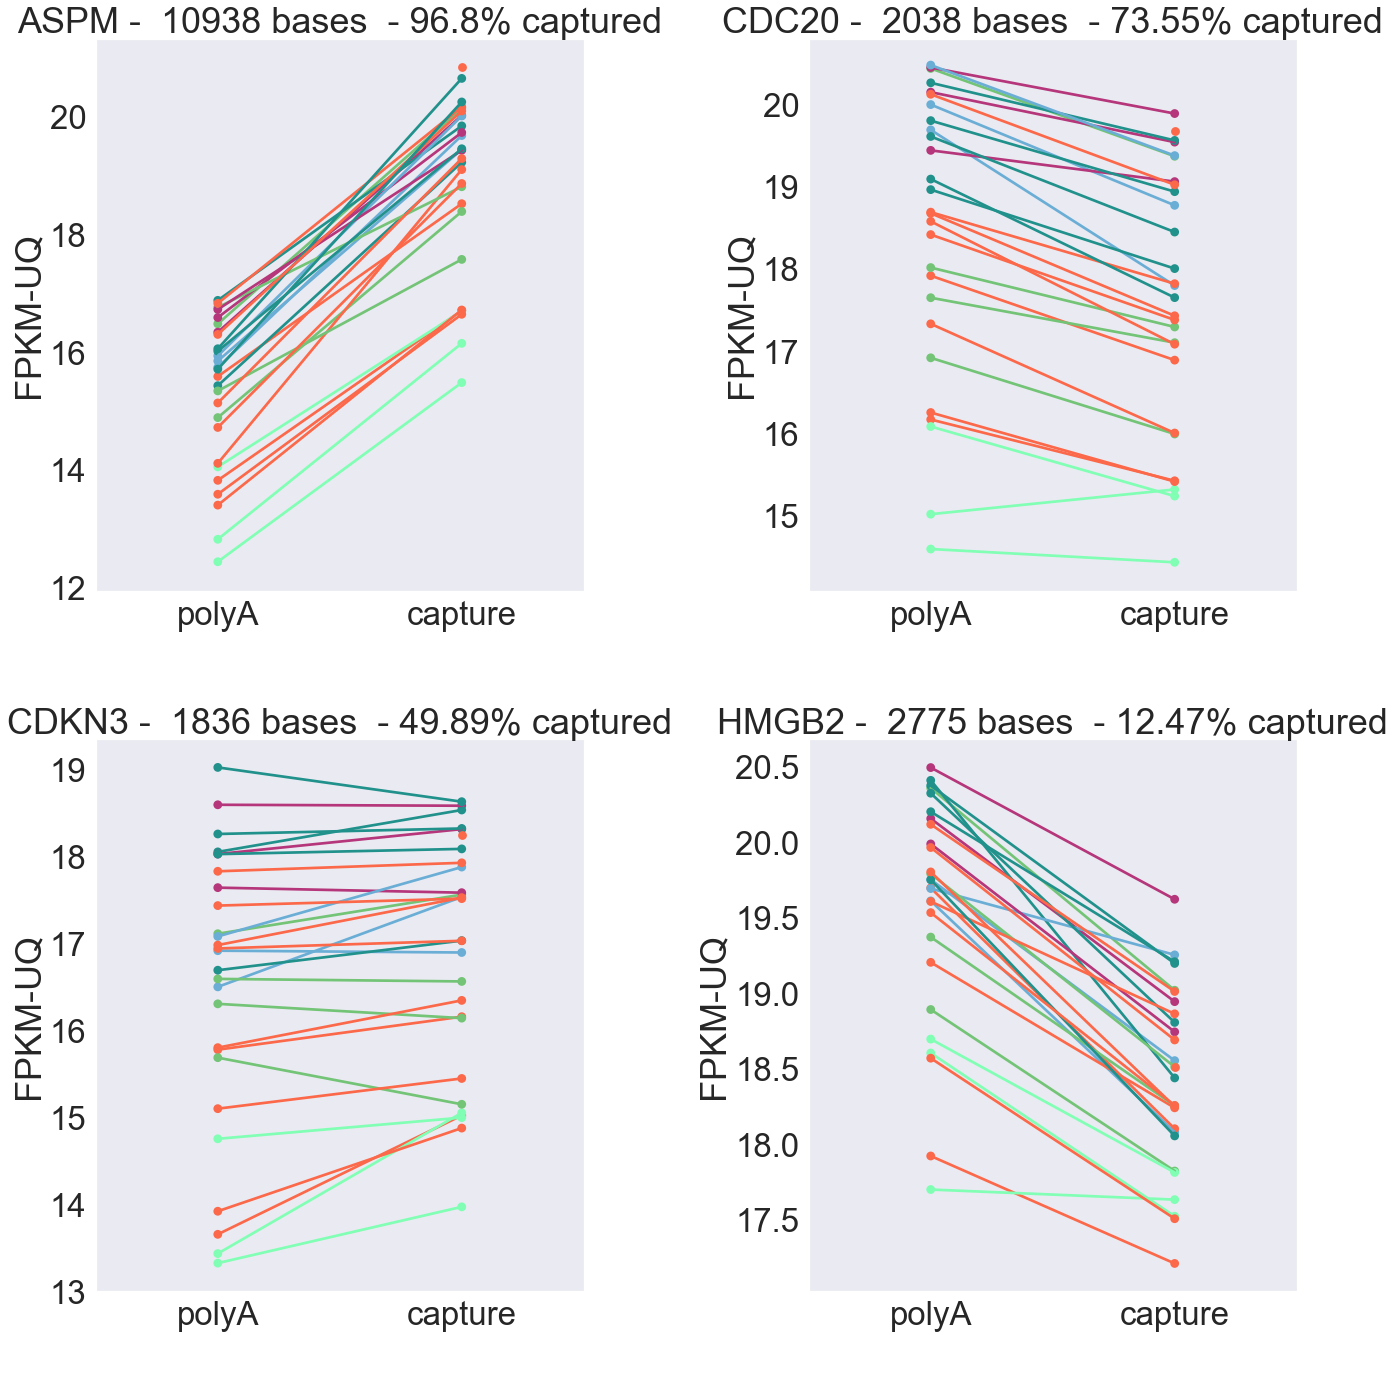

In [37]:
multi_catplot_polyA_bet_capture(genes_profile, ['ASPM','CDC20', 'CDKN3','HMGB2'])

In [76]:
def polyA_capture_foldchange(gene_name, genes_profile=genes_profile, tissues = tissue_types):
    """Finding differences in expression levels between capture and polyA to make a fold-change table"""
    genes_profile = pd.DataFrame.copy(genes_profile)
    gene_profile = genes_profile.loc[[0,'tissue',gene_name]].T.reset_index()
    polyAs = gene_profile[gene_profile['index'] == 'polyA'].rename(columns={gene_name:'polyA'})
    captures = gene_profile[gene_profile['index'] == 'capture'].rename(columns={gene_name:'capture'})
    foldchange_table = pd.merge(polyAs, captures, on=[0], how = 'outer').dropna()
    foldchange_table = foldchange_table[~((foldchange_table.capture == 0)|(foldchange_table.polyA == 0))]
    foldchange_table['fold_change'] = foldchange_table['capture']- foldchange_table['polyA']   
    return foldchange_table

def polyA_capture_fc_percent_analysis(foldchange_table, trivial = True):
    """return percentages of genes are the same (pos for positive) or opposite (neg for negative) fold_changes"""
    foldchange_table = pd.DataFrame.copy(foldchange_table)
    pos_foldchange_table = foldchange_table[foldchange_table['fold_change'] >=0.]
    neg_foldchange_table = foldchange_table[foldchange_table['fold_change'] <0.]
    if pos_foldchange_table.shape[0] > neg_foldchange_table.shape[0]:
        more_fc_table = pos_foldchange_table
        less_fc_table = neg_foldchange_table
    else:
        more_fc_table = neg_foldchange_table
        less_fc_table = pos_foldchange_table

    num_trivial_fc = less_fc_table[np.abs(less_fc_table['fold_change'])<=1.].shape[0]
    if trivial:
        return (more_fc_table.shape[0]+num_trivial_fc)/foldchange_table.shape[0]
    else:
        return more_fc_table.shape[0]/foldchange_table.shape[0]
    

Rename/ reconstruct data to all log 2 data tables

In [39]:
data = collect_sample(sp_name=sp_names[18] , data=cp_edata_pcg)

In [40]:
log2_edata_pcg = pd.concat([cp_edata_pcg[cp_edata_pcg.columns[:3]],np.log2(cp_edata_pcg[cp_edata_pcg.columns[3:]]+1)], axis=1)

In [41]:
polyA = log2_edata_pcg[log2_edata_pcg.sample_type=='FF.polyA'].T.iloc[3:]
polyA = pd.DataFrame(polyA.stack()).reset_index().rename(columns={ 'level_0':'gene_name', 0 : 'FPKM_polyA'})
polyA['sample'] = polyA['sample'].str.split('-').transform(lambda x: '-'.join(x[:3]))

In [42]:
capture = log2_edata_pcg[log2_edata_pcg.sample_type=='FFPE.capture'].T.iloc[3:]
capture = pd.DataFrame(capture.stack()).reset_index().rename(columns={ 'level_0':'gene_name', 0 : 'FPKM_capture'})
capture['sample'] = capture['sample'].str.split('-').transform(lambda x: '-'.join(x[:3]))

In [43]:
gene_names = np.array(complete_gene_info.gene_name)

An important step to find how many genes have the same trend of fold-change and genes passed are those having at least 70% of the same trend.

In [44]:

gene_pass_list = []
gene_not_pass_list = []

for gene in gene_names:
    #gene = gene_names[1700]

    combine_foldchange = pd.merge(capture[capture['gene_name'] == gene], \
                                      polyA[polyA['gene_name']==gene], on =['sample'], how='outer')
    combine_foldchange['fold_change'] = combine_foldchange.FPKM_polyA - combine_foldchange.FPKM_capture
    combine_foldchange.dropna(inplace = True)
    combine_foldchange = combine_foldchange[~((combine_foldchange.FPKM_capture == 0)|(combine_foldchange.FPKM_polyA == 0))]
    
    if (combine_foldchange.shape[0]>0) and (polyA_capture_fc_percent_analysis(combine_foldchange, trivial=False)>=0.7):
        gene_pass_list.append(gene)
    else:
        gene_not_pass_list.append(gene)
    

In [49]:
update_log2_edata_pcg = pd.DataFrame.copy(log2_edata_pcg) #copy before edit

In [50]:
"""Adding correction factors for passed genes"""
def polyA_capture_fc_analysis(gene):
    foldchange_table = polyA_capture_foldchange(gene)
    pos_foldchange_table = foldchange_table[foldchange_table['fold_change'] >=0.]
    neg_foldchange_table = foldchange_table[foldchange_table['fold_change'] <0.]
    if pos_foldchange_table.shape[0] > neg_foldchange_table.shape[0]:
        more_fc_table = pos_foldchange_table
        less_fc_table = neg_foldchange_table
    else:
        more_fc_table = neg_foldchange_table
        less_fc_table = pos_foldchange_table

    return more_fc_table

for gene in gene_pass_list:
    update_log2_edata_pcg[gene][update_log2_edata_pcg['sample_type']=='FF.polyA'] +=np.mean(polyA_capture_fc_analysis(gene).fold_change)
    

In [74]:
def normalized_plot_polyA_capture(ori_data, data, tissue_name, gene_pass_list = gene_pass_list):
    """plotting before and after adding correction factors plots"""
    data = pd.DataFrame.copy(data)
    ori_data = pd.DataFrame.copy(ori_data)

    data = data.iloc[np_subwhere(data.index,tissue_name)]
    data = data[data.sample_type.isin(['FF.polyA','FFPE.capture'])].T
    data.columns = data.loc['sample_type']
    data = data.iloc[3:].astype(float)
    
    ori_data = ori_data.iloc[np_subwhere(ori_data.index,tissue_name)]
    ori_data = ori_data[ori_data.sample_type.isin(['FF.polyA','FFPE.capture'])].T
    ori_data.columns = ori_data.loc['sample_type']
    ori_data = ori_data.iloc[3:].astype(float)
    
    genes_off_target = ori_data[(ori_data['FF.polyA'] * ori_data['FFPE.capture']==0)].index.tolist()
    data=data.loc[~data.index.isin(genes_off_target)]
    ori_data = ori_data.loc[~ori_data.index.isin(genes_off_target)]
    
    sns.set(style="dark", color_codes=True, font_scale=1.5, rc={'figure.figsize':(11.7,8.27)})
    slope, intercept, r_value, p_value, std_err = stats.linregress(ori_data['FF.polyA'], ori_data['FFPE.capture'])
    
    a = sns.regplot(x='FF.polyA', y="FFPE.capture", data=ori_data, scatter=True,\
         label = 'original: y = '+str(round(slope,2))+'x + '+str(round(intercept,2))+ '\n R^2 = '+str(round(r_value**2,2)),\
                   scatter_kws={"alpha":0.05, 'color':'blue','s':2})
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['FF.polyA'], data['FFPE.capture'])
    
    
    a = sns.regplot(x='FF.polyA', y="FFPE.capture", data=data, scatter=True,\
         label = 'adjusted: y = '+str(round(slope,2))+'x + '+str(round(intercept,2))+ '\n R^2 = '+str(round(r_value**2,2)),\
                    scatter_kws={"alpha":0.05, 'color':'black','s':2})
    plt.legend(loc='best')
    plt.title(sp_names[2])


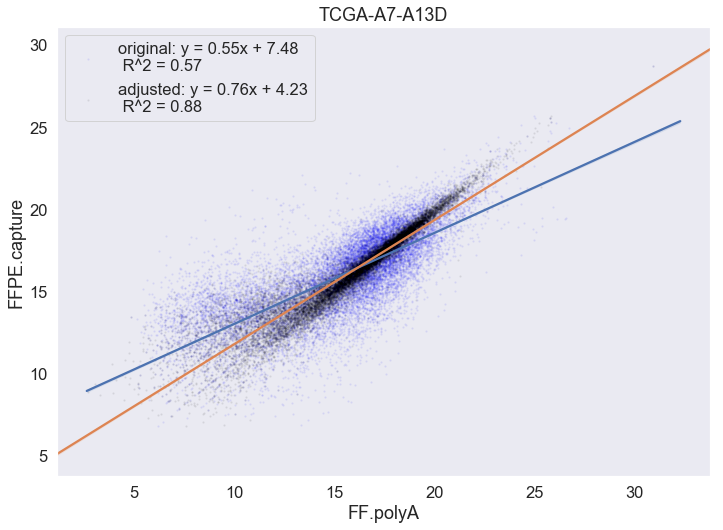

In [75]:
arr = normalized_plot_polyA_capture(log2_edata_pcg, update_log2_edata_pcg, sp_names[2])

Our algorithm has shown the correlation coefficients have increases from 0.57 to 0.88. Some tissues get 0.95 in that number. 